<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/NU/Lab4_Alpha_range.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab4 Nuclear Experiment. Alpha range

Evgeny Kolonsky

v.0.1.5

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

Set #1

Po-210 dated 10.2024

Constants and parameters

In [50]:
di = 10 # distance between shelves, mm
d0 = 12.3 # distance between top shelf and GM counter window, mm
r = 31.6 / 2 # GM window radius, mm
shelf_thickness = 2.0 # sample shelf thickness, mm
tablet_thikness = 3.4 # Po-210 sample is slighly over the shelf, mm
tablet_inner_radius = 6.1 /2 # mm
sample_height = 1.0 # mm estimated. Polonium source is small amount on the bottom of inner hole of the tablet
rho_mica = 2.0 # mg/cm2, GM window areal density
rho_air  = 1.1 # mg/cm3, air density at 55 rel humidity 25C room temperature
rho_air_err = 0.1 # mg/cm3, air density error
rho_rel = rho_air_err / rho_air # relative error
h0 = rho_mica / rho_air * 10 #  path in air equivalent to path in mica window
h0_err = h0 * rho_rel
I_background = 0.29 # counts /s
E_alpha = 5.3 #MeV, decay energy reference for Po-210
# Expected range, mg/cm2
R1 = 0.4 * E_alpha**1.5
# Expected range, mm
R2 = 3.2 * E_alpha**1.5
# spacers
spacers_height = np.array([0, 1.06, 1.98, 2.92, 4.16, 5.02, 6.10, 7.02, 8.10, 9.02])  # spacers height +- 0.02 mm

Solid angle
$$
\Omega = 2 \pi \left( 1 - \frac{1}{\sqrt{1+(r/h)^2}}\right)
\tag{13}
$$

Range as length
$$
R = 0.32 \, {E_\alpha} ^{3/2}
\tag{5}
$$
where $E_{\alpha}$ measured in `MeV`, range $R$ in `cm`.

Range as areal density
$$
R = 0.4 \, {E_\alpha} ^{3/2}
\tag{5}
$$
where $E_{\alpha}$ measured in `MeV`, range $R$ in `mg/cm2`.

Measurements

<ipython-input-51-bdbdf3dd6ff5>:61: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  h_TLV = fsolve(g, h_new.max())[0]


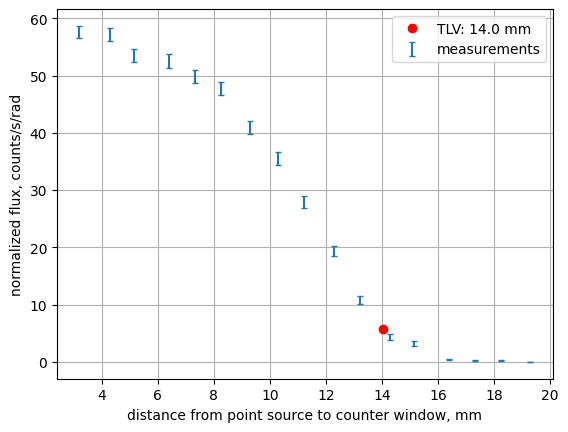

In [51]:
data = '''
# shelf#, spacers/mm, counts, time/s
# measured 17.11.2024
1 0 7819 60
2 0 80 143
2 2.5 80 110
2 5.0 289 64
2 7.5 3625 84
2 8.0 3681 60
2 8.2 4953 61
2 9.0 1718 21
2 9.0 3559 45
2 9.0 3138 35
1 0.7 9366 61
1 3.0 9202 43
1 6.0 10721 37
'''

data = '''
# shelf#, spacer#, time/s, counts,
# measured 21.11.2024 with spacers
2 0 10 3
2 1 10 6
2 2 10 7
2 3 10 10
2 4 10 66
2 5 10 93
2 6 10 247
2 7 10 472
2 8 10 743
2 9 10 1017
1 0 10 1268
1 1 10 1615
1 2 10 1817
1 3 10 2068
1 4 10 2322
1 5 10 2657
1 6 10 2903
'''

n, spacer, time, counts = np.loadtxt(data.splitlines(), unpack=True, dtype=int)
# distance from sourse to GM counter window
h = d0 + (n - 1) * di - shelf_thickness - sample_height - spacers_height[spacer]

# solid angle
omega = 2 * np.pi * (1 - 1 / np.sqrt(1 + (r / h)**2))
# intensity
delta = 1 / np.sqrt(counts) # relative error
I = counts / time
I -= I_background
flux = I / omega
flux_err = delta * flux

#interpolate to find TLV
f = interp1d(h, flux, kind='slinear', fill_value='extrapolate')
h_new = np.linspace(h.min(), h.max(), 100)
flux_new = f(h_new)
# find TLV
TLV = np.max(flux) / 10
g = lambda x: f(x) - TLV
h_TLV = fsolve(g, h_new.max())[0]

#
plt.errorbar(h, flux, yerr=flux_err, linestyle='', capsize=2, label='measurements');
#plt.plot(h_new, flux_new, color='lightgray');
plt.plot(h_TLV, f(h_TLV), 'o', color='red', label=f'TLV: {h_TLV:.1f} mm')
plt.xlabel('distance from point source to counter window, mm')
plt.ylabel('normalized flux, counts/s/rad')
plt.legend()
plt.grid();

In [52]:
print(f'Observed range TLV: {h_TLV:.0f} mm + effective path in mica {h0:.0f} mm = {h_TLV +h0:.0f} ± {h0_err:.0f} mm')
print(f'Expected range for E = {E_alpha} MeV: {R2:.0f} mm')

Observed range TLV: 14 mm + effective path in mica 18 mm = 32 ± 2 mm
Expected range for E = 5.3 MeV: 39 mm


# GM Specification data

Effective range is limited by GM mica window.

According to counter [documentation](https://www.lip.pt/~patricia/FisicaDaRadiacao/Geiger-Mueller-Detectors-Canberra-sheet.pdf) (fig. below) we expect to have range 15 mm for energy over 2.6 MeV.


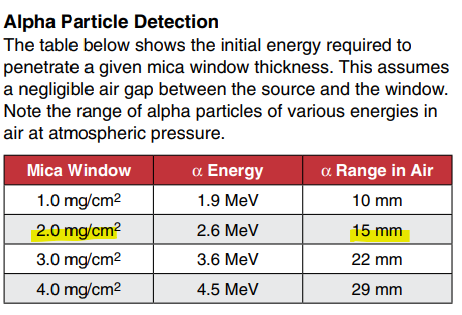

# From linear distance to areal density

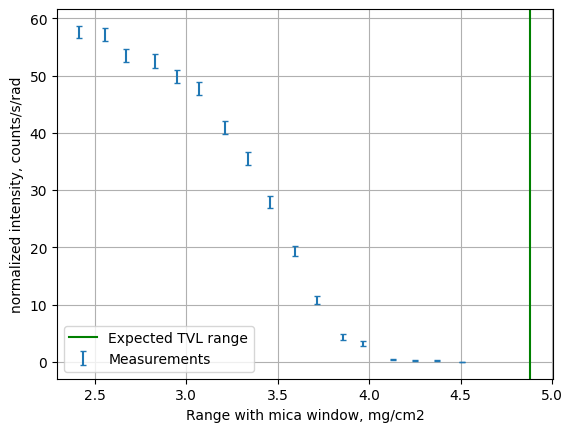

In [ ]:
w = h/10 * rho_air + rho_mica # aerial density units mg/cm2
plt.errorbar(w, flux, yerr=flux_err, linestyle='', capsize=2, label='Measurements')
plt.axvline(R1,  color='green', label='Expected TVL range')
plt.xlabel('Range with mica window, mg/cm2')
plt.ylabel('normalized intensity, counts/s/rad')
plt.legend()
plt.grid()

**Conclusion**

Observed TLV range 14 mm  summed with air equivalent of path 18 ± 2 mm in mica window having areal density 2 mg/cm2  gives total range 32 ± 2 mm.

Expected alpha particle range for energy E = 5.3 MeV is 39 mm.

Difference could be explained by additional distance that particle travels inside GM counter before avalanche happens.